In [35]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt



In [36]:
'''Step 1: Counting n-neighbours for atoms'''

def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

'''Step 2: Counting n-neighbours for amino acids'''

def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """
    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in data if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        for key in keys_to_remove:
            atom.pop(key, None)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")

    return ca_atoms

def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

def merge_residue_data(conservation_scores, neighbour_counts):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    
    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for score_entry in conservation_scores:
        residue_id = score_entry['residue_id']
        residue_name = score_entry['residue_name']
        
        # Find the corresponding entry in neighbour_counts
        neighbour_entry = neighbour_dict.get((residue_id, residue_name))
        
        if neighbour_entry:
            # Merge the two entries
            merged_entry = {
                'residue_id': residue_id,
                'residue_name': residue_name,
                'conservation_score': score_entry['conservation_score'],
                'neighbour_count': neighbour_entry['neighbour_count']
            }
            merged_data.append(merged_entry)
    
    return merged_data

def plot_and_calculate_correlation(data, title, angstrom, num_residues=1600):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot neighbour counts
    ax1.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    ax1.set_xlabel('Residue ID')
    ax1.set_ylabel('Neighbour Count', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        ax2 = ax1.twinx()  # Instantiate a second y-axis
        ax2.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        ax2.set_ylabel('Conservation Score', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")
    
    plt.title(f'{title}: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    
    # Set plot limits for residue IDs
    ax1.set_xlim(0, num_residues)
    
    # Display the plot
    fig.tight_layout()
    plt.show()


In [37]:
def pdb_to_n_neighbour_vector(pdb_file_path, angstrom):
    '''Step 1: Counting n-neighbours for atoms'''
    # convert_cif_to_pdb(cif_file_path, pdb_file_path)
    amino_vector = []
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)

    amino_acid_info_count = find_nearest_neighbors(atom_info_list, angstrom)

    print(f"Number of Amino Acids: {len(amino_acid_info_count)}")
    conservation_scores = extract_conservation_score(filename=f"conservation_scores/{title}_consurf_summary.txt")
    print(conservation_scores)

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, amino_acid_info_count)
        print(merged_residues)
        plot_and_calculate_correlation(merged_residues, title, angstrom)
    else:
        print("Conservation scores not found, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = amino_acid_info_count
        plot_and_calculate_correlation(merged_residues, title, angstrom)

    return merged_residues

def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = max(ref_seq_entry['neighbour_count'], entry['neighbour_count'])
            if 'conservation_score' in entry:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq



Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9     \
1      0.000   3.752   7.576  10.522  13.273  16.894  19.129  21.499  24.692   
2      3.752   0.000   3.904   6.805   9.644  13.326  15.789  18.440  21.658   
3      7.576   3.904   0.000   3.162   6.654  10.276  13.285  16.315  19.414   
4     10.522   6.805   3.162   0.000   3.868   7.249  10.537  13.714  16.695   
5     13.273   9.644   6.654   3.868   0.000   3.824   6.733  10.086  13.228   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1612  62.208  63.840  65.067  66.213  68.513  69.595  71.713  71.629  71.820   
1613  62.779  64.225  65.235  66.259  68.548  69.500  71.692  71.630  71.708   
1614  60.155  61.655  62.693  63.814  66.244  67.332  69.658  69.776  70.004   
1615  62.166  63.839  65.040  66.298  68.821  70.058  72.410  72.600  72.952   
1616  65.505  67.072  68.151  69.316  71.791  72.911  

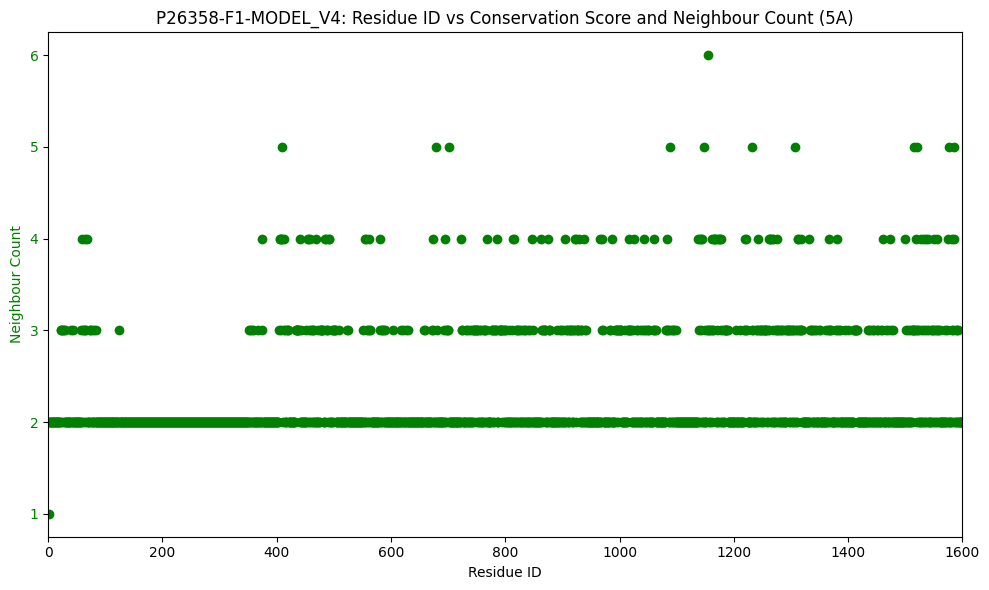

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8012.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8032.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8033.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8100.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        350     351     352     353     354     355     356     357     358  \
350   0.000   3.840   6.619  10.080  12.522  15.215  14.354  11.191   9.861   
351   3.840   0.000   3.830   6.922   9.073  12.052  11.932   9.120   8.552   
352   6.619   3.830   0.000   3.763   6.111   8.610   8.144   5.349   5.365   
353  10.080   6.922   3.763   0.000   3.808   5.403   5.764   4.870   5.411   
354  12.522   9.073   6.111   3.808   0.000   3.828   6.070   5.686   8.163   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
595  43.599  43.543  40.458  40.392  39.908  38.055  35.391  35.675  36.728   
596  44.233  44.399  41.383  41.379  41.230  39.324  36.417  36.695  37.373   
597  47.622  47.837  44.868  44.940  44.696  42.862  40.017  40.215  40.980   
598  48.583  48.505  45.355  45.131  44.681  42.631  39.976  40.487  41.437   
599  47.596  47.530  44.331  43.974  43.758  41.522  38.734  39.4

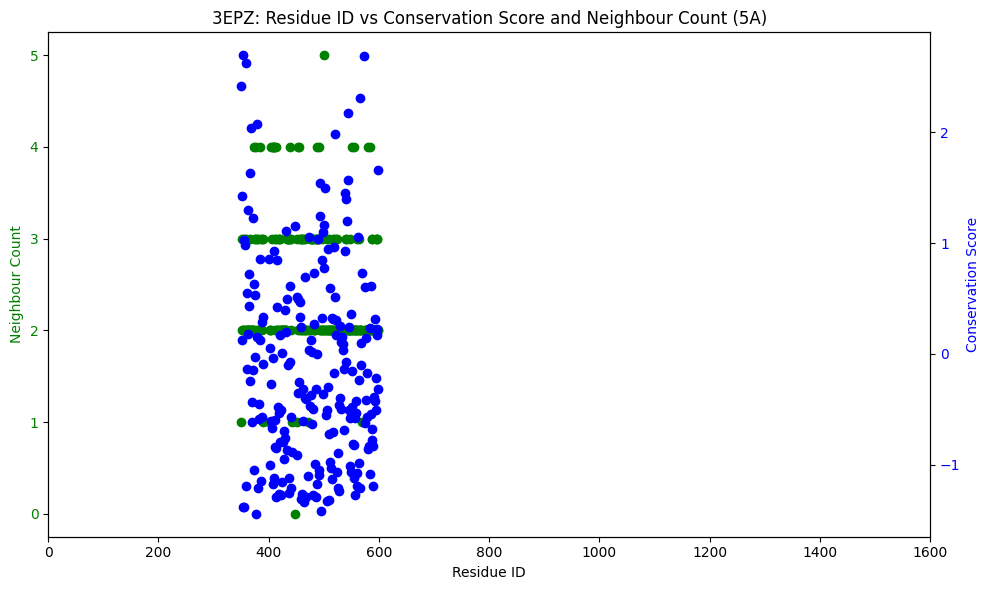

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8646.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        647     648     649     650     651     652     653     654     655   \
647    0.000   3.804   6.749  10.286  13.369  17.139  19.565  22.393  25.214   
648    3.804   0.000   3.817   6.823   9.899  13.668  15.871  18.760  21.491   
649    6.749   3.817   0.000   3.818   6.828  10.501  13.234  16.196  18.951   
650   10.286   6.823   3.818   0.000   3.808   7.196   9.705  12.962  15.415   
651   13.369   9.899   6.828   3.808   0.000   3.808   6.613   9.474  12.277   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1597  43.982  43.193  45.581  45.093  47.207  48.816  47.430  49.689  49.333   
1598  44.304  43.610  46.179  45.845  47.902  49.640  48.241  50.366  50.189   
1599  43.922  43.542  46.270  46.209  48.510  50.466  49.335  51.647  51.659   
1600  46.515  46.244  49.096  49.151  51.415  53.443  52.296  54.504  54.605   
1601  21.250  19.076  20.330  18.968  20.858  22.262  

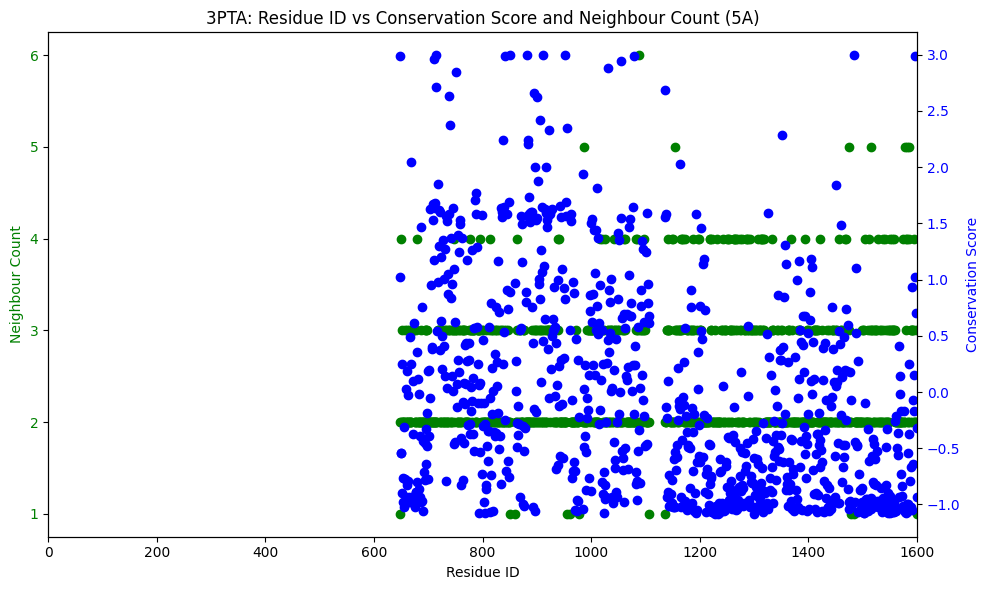

Distance matrix between CA atoms (formatted to 3 decimal places):
        601     602     603     604     605     606     607     608     609   \
601    0.000   3.819   5.527   7.226   7.983  10.778   9.049  12.048  10.727   
602    3.819   0.000   3.809   7.076   7.619  11.202  10.510  13.902  13.094   
603    5.527   3.809   0.000   3.806   5.682   8.933   8.250  11.430  10.925   
604    7.226   7.076   3.806   0.000   3.825   5.758   4.884   7.922   8.188   
605    7.983   7.619   5.682   3.825   0.000   3.814   5.196   8.877  10.248   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1597  53.768  57.395  58.523  58.092  59.042  58.736  55.527  54.270  51.860   
1598  54.235  57.775  59.096  58.907  59.883  59.813  56.589  55.540  53.002   
1599  54.205  57.712  58.917  58.754  59.964  59.930  56.582  55.440  52.739   
1600  57.826  61.315  62.492  62.337  63.616  63.577  60.196  59.001  56.263   
300   29.801  33.607  34.026  32.881  33.736  32.922  

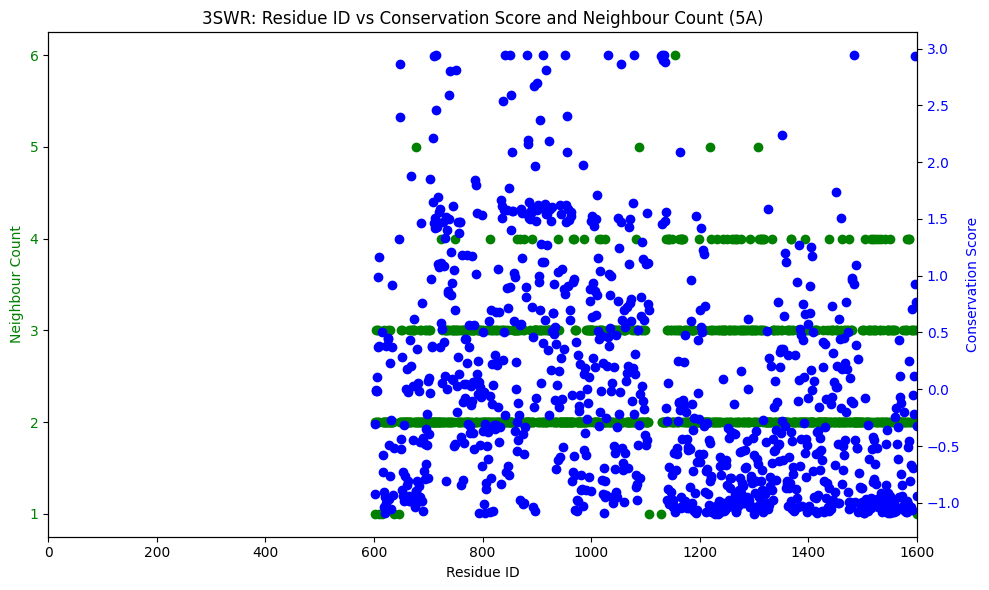

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19610.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19641.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19672.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19983.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        351     352     353     354     355     356     357     358     359   \
351    0.000   3.808   7.031   9.283  12.070  11.662   9.664   8.705   5.712   
352    3.808   0.000   3.801   6.457   8.602   7.864   6.043   5.523   4.007   
353    7.031   3.801   0.000   3.803   5.345   5.534   5.793   5.873   6.223   
354    9.283   6.457   3.803   0.000   3.805   6.205   7.058   8.816   9.680   
355   12.070   8.602   5.345   3.805   0.000   3.806   6.513   8.501  10.683   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1602  86.650  85.820  87.984  88.992  88.312  85.284  82.596  83.089  84.058   
1603  88.998  88.067  90.140  91.037  90.281  87.304  84.686  85.298  86.382   
1604  89.565  88.624  90.684  91.434  90.722  87.848  85.217  85.985  87.097   
1605  92.581  91.636  93.684  94.340  93.647  90.840  88.211  89.075  90.204   
1706  56.974  55.659  57.413  58.898  57.700  54.297  

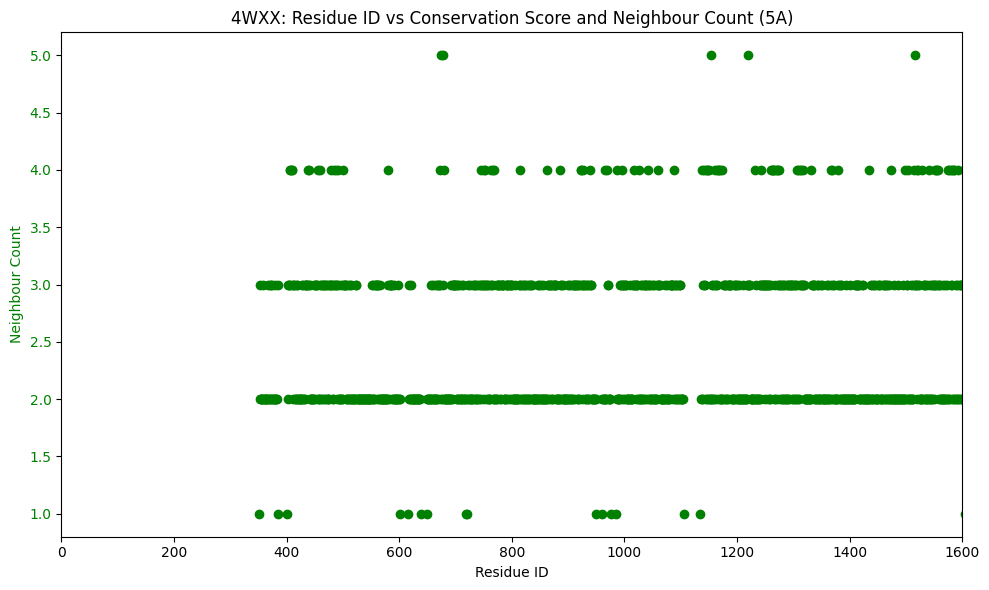

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12168.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12179.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        615     616     617     618     619     620     621     622     623   \
615    0.000   3.812   5.793   7.284   9.162  12.666  16.330  18.358  20.572   
616    3.812   0.000   3.803   6.371   9.448  12.235  15.909  17.432  19.397   
617    5.793   3.803   0.000   3.796   6.595   8.914  12.426  13.702  15.855   
618    7.284   6.371   3.796   0.000   3.789   6.037   9.795  11.862  13.540   
619    9.162   9.448   6.595   3.789   0.000   3.785   7.295   9.946  12.012   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  37.460  37.905  36.228  32.436  30.822  29.139  27.906  30.300  27.806   
1597  41.234  41.681  40.020  36.229  34.615  32.894  31.568  33.855  31.274   
1598  42.055  42.206  40.326  36.565  35.002  32.921  31.315  33.243  30.384   
1599  40.520  40.777  38.670  34.917  33.047  30.859  28.979  30.819  28.094   
1600  43.547  43.952  41.763  38.020  35.937  33.748  

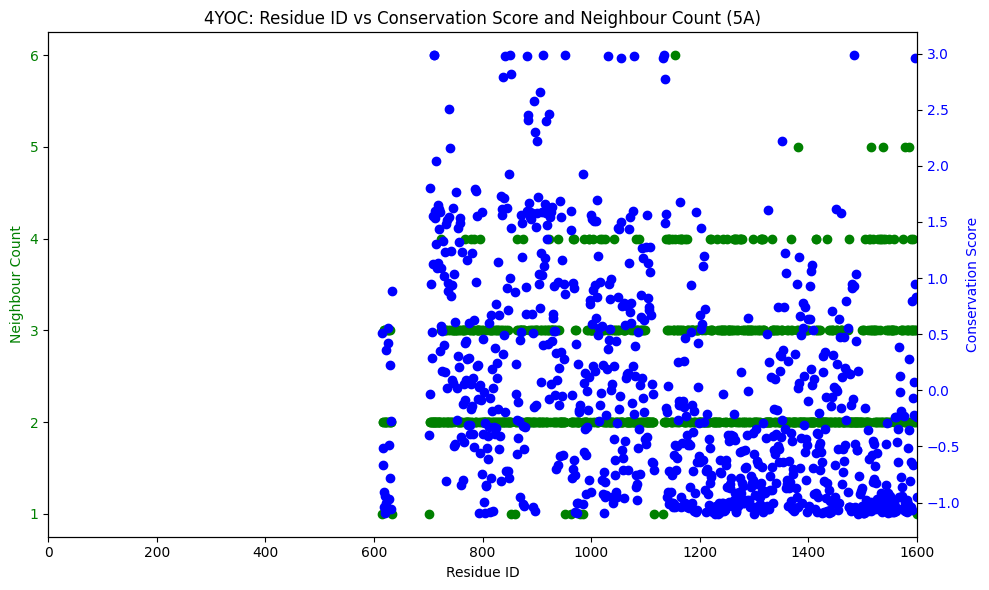

Distance matrix between CA atoms (formatted to 3 decimal places):
        555     556     557     558     559     560     561     562     563   \
555    0.000   2.854   5.033   5.776   8.449  11.270  10.781  13.579  15.881   
556    2.854   0.000   3.802   6.299   9.446  11.839  10.402  13.041  15.692   
557    5.033   3.802   0.000   3.816   6.757   8.674   6.827   9.246  12.032   
558    5.776   6.299   3.816   0.000   3.795   5.618   5.274   8.337  10.178   
559    8.449   9.446   6.757   3.795   0.000   3.806   5.620   7.376   8.846   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1079  81.856  79.994  81.808  85.520  87.504  89.880  87.220  87.289  90.979   
1080  81.512  79.747  81.609  85.277  87.166  89.662  87.123  87.187  90.914   
1081  79.202  77.508  79.494  83.131  85.057  87.632  85.162  85.348  89.082   
1082  75.906  74.271  76.316  79.921  81.827  84.470  82.071  82.307  86.052   
1083  72.128  70.473  72.505  76.119  78.041  80.666  

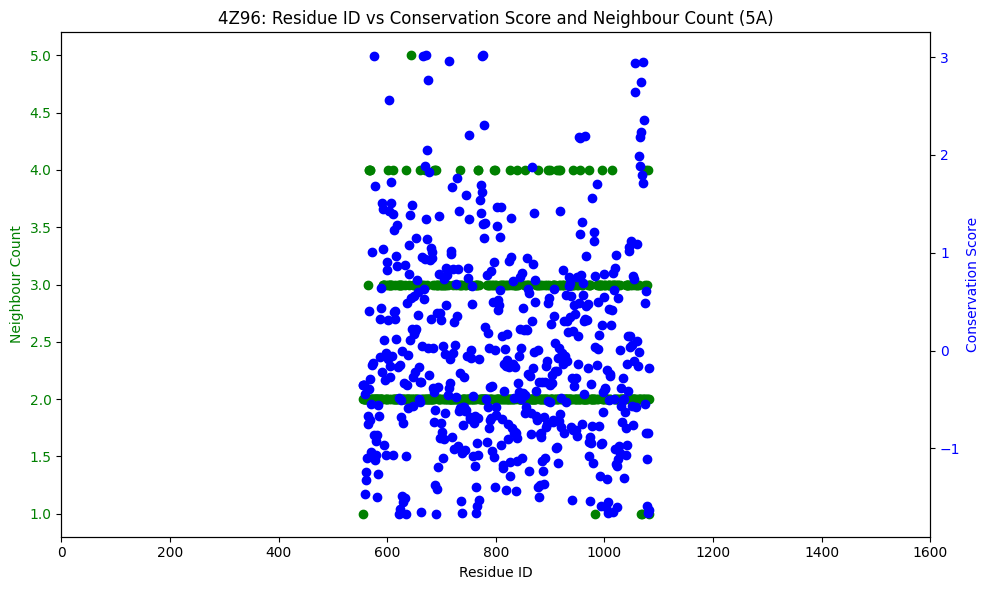

Distance matrix between CA atoms (formatted to 3 decimal places):
        555     556     557     558     559     560     561     562     563   \
555    0.000   2.821   5.112   5.914   8.291  11.315  10.890  13.554  16.060   
556    2.821   0.000   3.814   6.186   9.274  11.701  10.334  13.044  15.803   
557    5.112   3.814   0.000   3.827   6.763   8.583   6.731   9.254  12.142   
558    5.914   6.186   3.827   0.000   3.798   5.611   5.312   8.395  10.342   
559    8.291   9.274   6.763   3.798   0.000   3.813   5.697   7.423   8.925   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1079  81.089  79.609  81.375  85.086  87.132  89.373  86.690  86.979  90.685   
1080  80.650  79.284  81.108  84.776  86.727  89.090  86.526  86.805  90.544   
1081  78.405  77.106  79.062  82.692  84.674  87.127  84.635  85.033  88.783   
1082  75.064  73.828  75.842  79.440  81.393  83.917  81.497  81.934  85.696   
1083  71.319  70.056  72.059  75.668  77.647  80.148  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8815.
  warnings.warn(


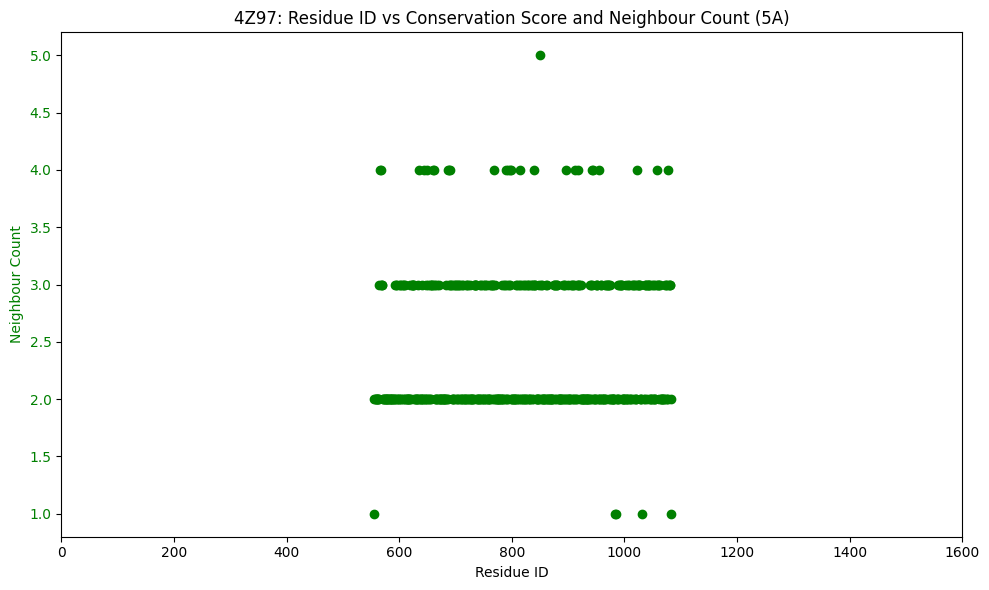

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3684.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3685.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3739.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3789.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3878.
  warnings.w

Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9   \
1    0.000   3.813   6.694  10.286  13.275  16.616  19.992  23.342  24.303   
2    3.813   0.000   3.787   6.826  10.060  13.209  16.633  19.996  20.699   
3    6.694   3.787   0.000   3.783   6.810   9.988  13.462  16.693  17.812   
4   10.286   6.826   3.783   0.000   3.798   6.421  10.006  13.212  14.085   
5   13.275  10.060   6.810   3.798   0.000   3.806   6.747  10.196  11.520   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
72  27.521  25.097  21.966  19.735  15.964  15.181  12.232  12.211  14.569   
73  29.504  26.784  23.788  21.180  17.399  16.122  12.682  12.245  13.740   
74  31.968  29.297  26.552  24.022  20.304  19.229  15.801  15.552  16.486   
75  35.328  32.519  29.678  26.929  23.204  21.672  18.019  17.066  17.709   
76  39.029  36.235  33.430  30.678  26.962  25.383  21.694  20.559  21.024  

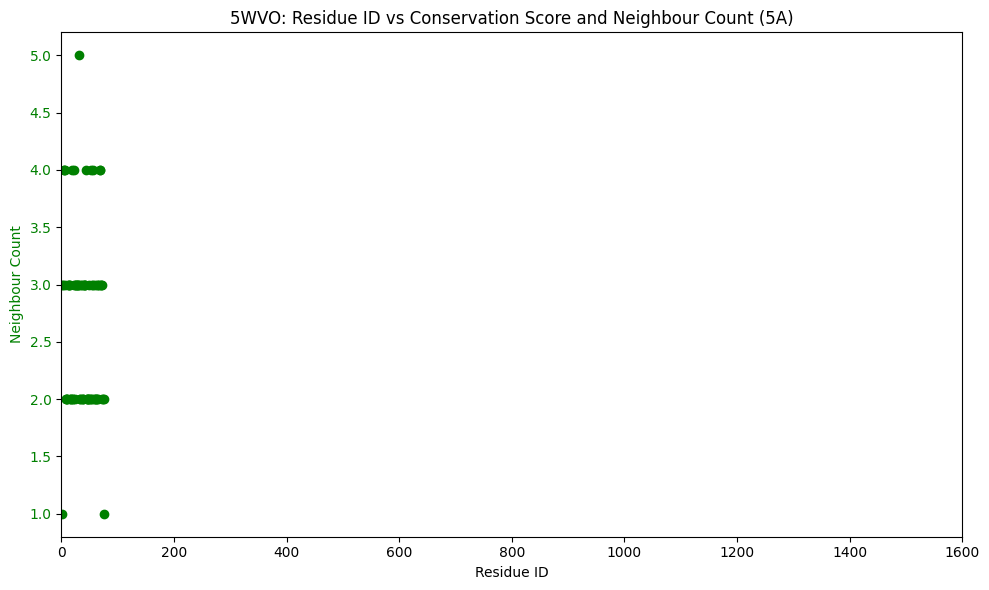

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3605.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3610.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3616.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3641.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3844.
  warnings.w

Distance matrix between CA atoms (formatted to 3 decimal places):
        -1       0       1       2       3       4       5       6       7   \
-1    0.000   3.795   6.685  10.322  13.137  16.836  19.373  22.899  25.724   
 0    3.795   0.000   3.740   6.929   9.861  13.425  15.949  19.493  22.259   
 1    6.685   3.740   0.000   3.788   6.603  10.311  13.213  16.534  19.611   
 2   10.322   6.929   3.788   0.000   3.807   7.069  10.301  13.397  16.562   
 3   13.137   9.861   6.603   3.807   0.000   3.779   6.890   9.972  13.229   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69  23.939  20.782  18.386  16.045  12.508   9.885   6.245   5.893   4.806   
 70  27.482  24.412  22.093  19.833  16.273  13.599   9.959   8.793   6.418   
 71  29.183  26.063  24.136  21.936  18.640  16.057  12.289  11.481   8.436   
 72  32.059  29.104  27.358  25.393  22.115  19.714  15.972  15.197  12.135   
 73  34.342  31.256  29.681  27.561  24.472  21.928  18.162  17.2

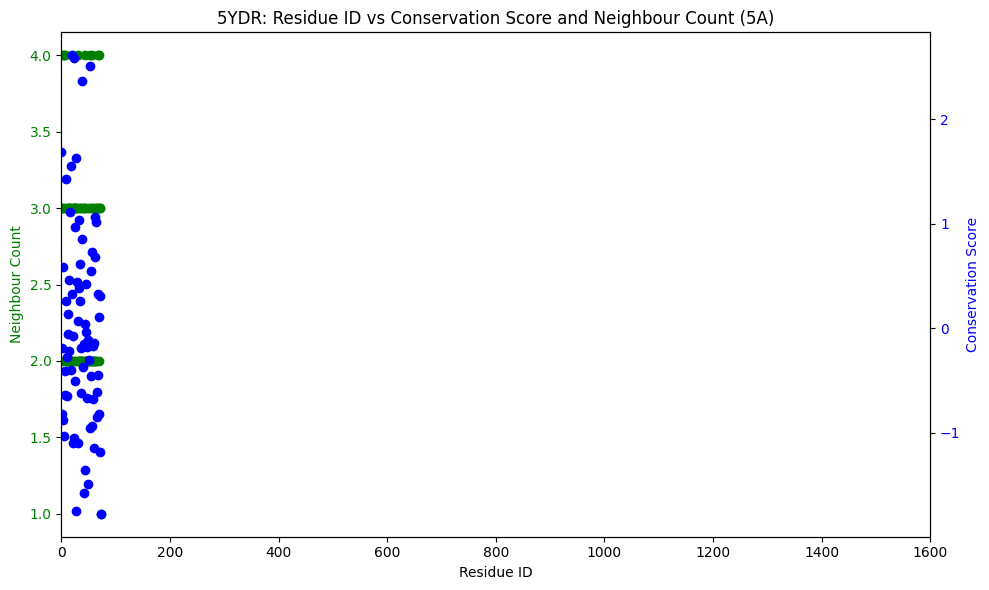

Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.806   6.761  10.290  13.394  16.631  19.924  22.144  20.372   
2     3.806   0.000   3.792   6.769  10.198  13.154  16.626  18.611  16.930   
3     6.761   3.792   0.000   3.803   6.636   9.939  13.167  15.511  14.027   
4    10.290   6.769   3.803   0.000   3.793   6.466   9.969  12.032  10.918   
5    13.394  10.198   6.636   3.793   0.000   3.780   6.569   9.306   8.635   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
253  40.650  37.905  38.602  36.511  37.958  35.825  37.744  34.846  33.873   
254  43.550  40.876  41.586  39.562  40.953  38.790  40.629  37.648  36.524   
255  46.133  43.557  44.440  42.485  44.022  41.940  43.868  40.944  39.914   
256  49.838  47.275  48.138  46.167  47.637  45.487  47.317  44.307  43.288   
257  51.277  48.906  49.967  48.213  49.835  47.848  49.816  46.8

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6322.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6328.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6330.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6344.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6347.
  warnings.w

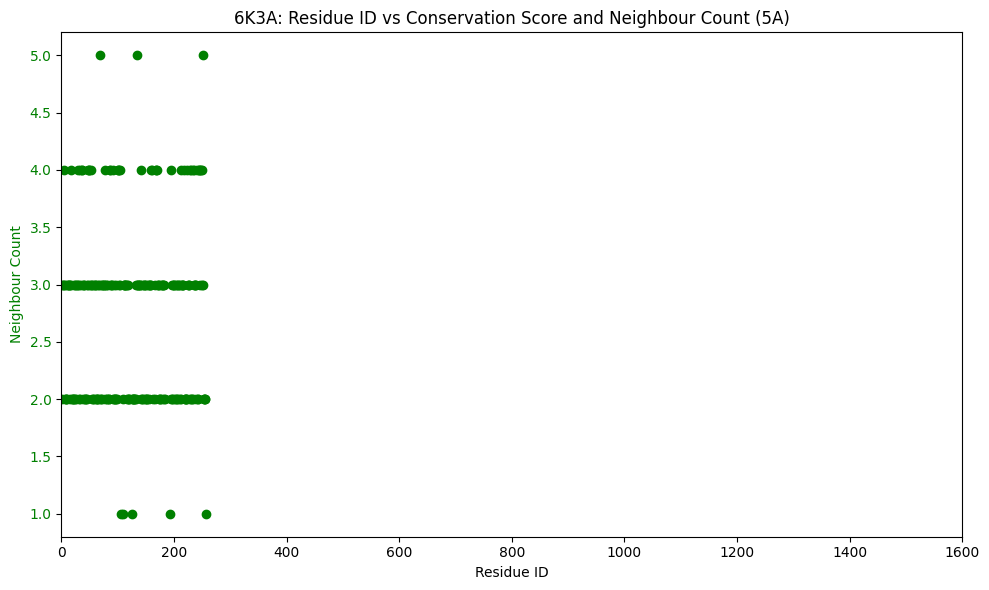

Distance matrix between CA atoms (formatted to 3 decimal places):
        140     141     142    143     144     145
140   0.000   3.821   6.976  9.531  10.835  13.685
141   3.821   0.000   3.829  6.027   7.968  10.659
142   6.976   3.829   0.000  3.823   6.996  10.043
143   9.531   6.027   3.823  0.000   3.782   6.444
144  10.835   7.968   6.996  3.782   0.000   3.802
145  13.685  10.659  10.043  6.444   3.802   0.000
Elapsed time: 0.00 seconds
Number of Amino Acids: 6
Error processing file conservation_scores/6L1F_consurf_summary.txt: list index out of range
None
Conservation scores not found, skipping merge_residue_data. Going straight to plotting.
Conservation scores not found. Plotting only Neighbour Count.


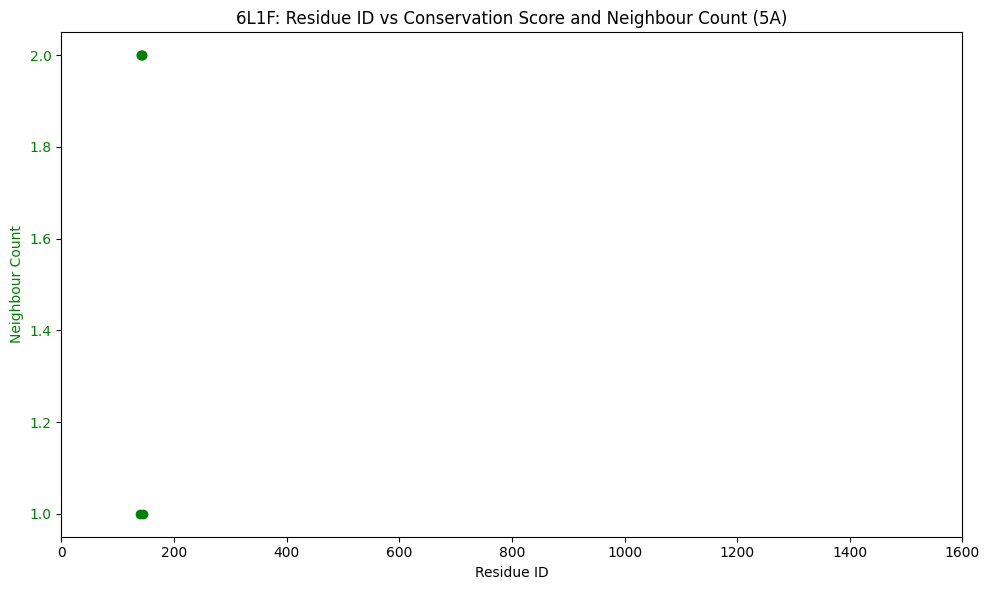

Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.820   6.329  10.030  12.723  15.678  17.136  18.743  21.644   
731    3.820   0.000   3.813   6.890   9.768  12.894  14.238  15.526  18.177   
732    6.329   3.813   0.000   3.798   6.792   9.458  10.849  12.672  15.604   
733   10.030   6.890   3.798   0.000   3.808   6.197   7.459   9.207  11.931   
734   12.723   9.768   6.792   3.808   0.000   3.798   6.735   9.209  11.221   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1597  55.029  51.511  51.678  49.046  48.043  48.561  48.219  45.751  42.470   
1598  51.332  47.794  47.939  45.300  44.357  44.881  44.499  42.004  38.758   
1599  50.272  46.764  46.882  44.254  43.069  43.680  43.596  41.362  38.120   
1600  52.784  49.216  49.100  46.306  44.910  45.274  45.157  42.960  39.566   
1701  66.572  63.923  65.533  64.140  63.809  65.669  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14267.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14525.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14529.
  warnings.warn(


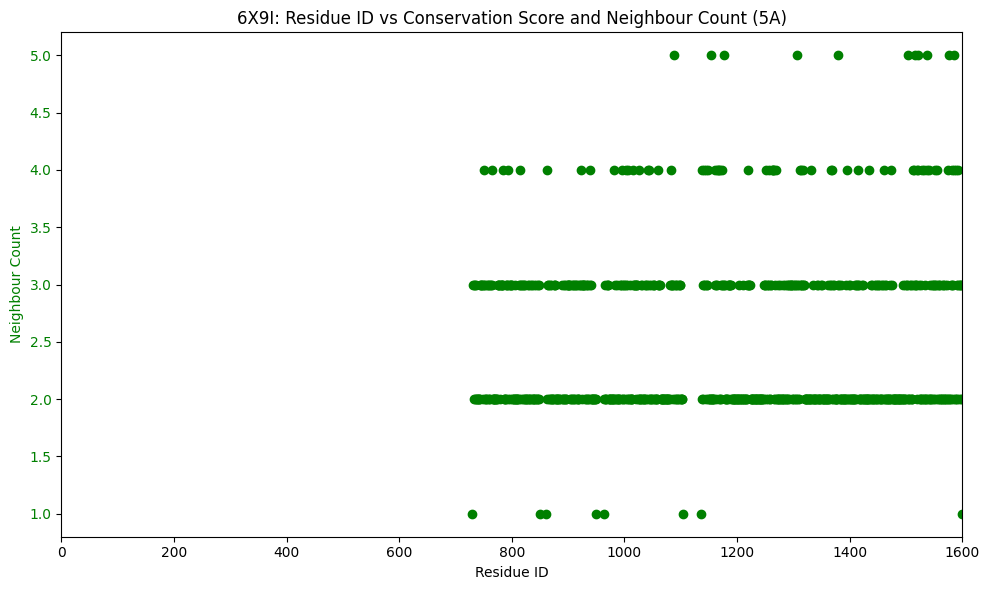

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14886.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14952.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14956.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14988.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15369.
  warni

Distance matrix between CA atoms (formatted to 3 decimal places):
        729     730     731     732     733     734     735     736     737   \
729    0.000   3.806   6.337   8.039  11.807  14.270  17.092  18.582  19.785   
730    3.806   0.000   3.824   6.789  10.392  12.709  16.024  17.871  18.805   
731    6.337   3.824   0.000   3.803   6.937   9.689  12.931  14.546  15.166   
732    8.039   6.789   3.803   0.000   3.798   6.549   9.443  11.082  12.249   
733   11.807  10.392   6.937   3.798   0.000   3.808   6.232   7.701   8.703   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  57.405  53.897  51.327  51.813  49.605  49.103  49.757  50.082  47.693   
1597  57.980  54.575  51.813  52.093  49.691  49.194  49.580  49.647  47.127   
1598  54.298  50.925  48.116  48.368  45.949  45.508  45.893  45.923  43.371   
1599  53.291  49.826  47.113  47.353  44.979  44.305  44.797  45.114  42.805   
1600  51.518  48.110  45.267  45.245  42.694  41.817  

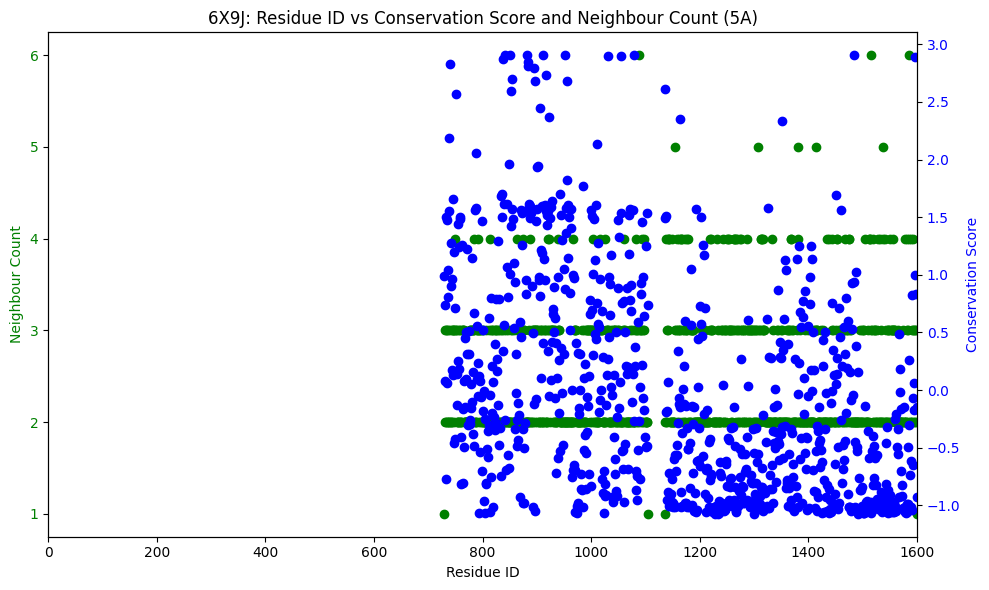

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14866.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14904.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14934.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15120.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15121.
  warni

Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.815   6.243   9.944  12.350  15.318  17.351  18.577  21.451   
731    3.815   0.000   3.800   7.020   9.994  12.984  14.693  15.395  18.112   
732    6.243   3.800   0.000   3.782   6.701   9.357  11.175  12.402  15.309   
733    9.944   7.020   3.782   0.000   3.808   6.173   7.879   8.940  11.627   
734   12.350   9.994   6.701   3.808   0.000   3.802   6.997   8.947  10.943   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  54.397  51.392  51.548  49.311  48.707  49.788  50.026  47.570  44.617   
1597  55.147  51.990  51.936  49.500  48.863  49.668  49.653  47.075  43.969   
1598  51.569  48.361  48.267  45.804  45.222  46.001  45.930  43.312  40.229   
1599  50.221  47.138  47.014  44.585  43.784  44.684  44.894  42.512  39.445   
1600  48.194  45.086  44.716  42.131  41.110  41.848  

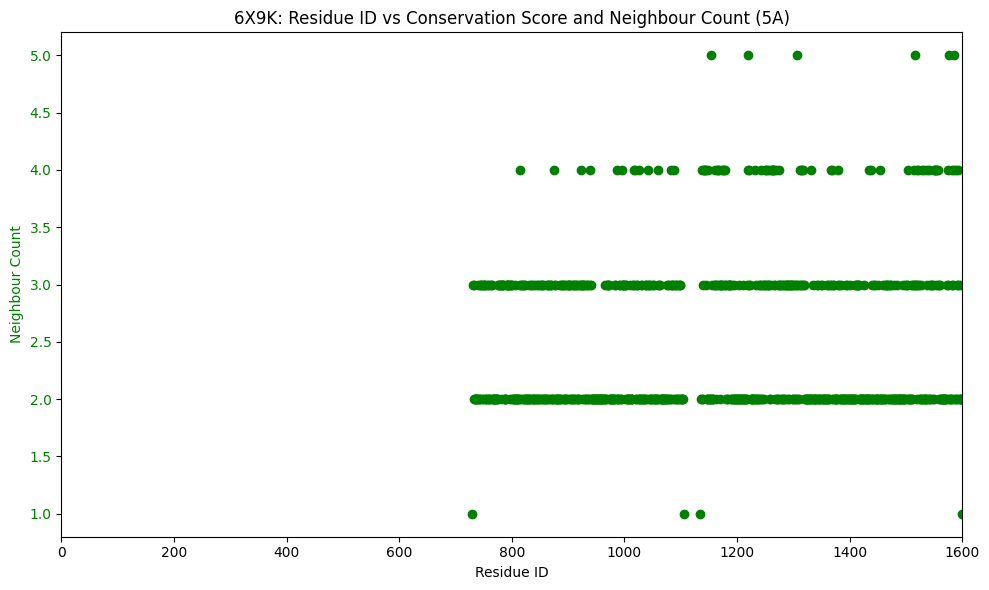

Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.815   6.041   9.749  12.254  15.409  17.316  18.050  20.837   
731    3.815   0.000   3.792   6.819   9.769  12.999  14.687  14.933  17.472   
732    6.041   3.792   0.000   3.780   6.449   9.471  11.379  12.279  15.030   
733    9.749   6.819   3.780   0.000   3.808   6.371   7.983   8.673  11.276   
734   12.254   9.769   6.449   3.808   0.000   3.797   6.925   8.740  10.682   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  54.795  51.442  51.639  49.351  48.718  49.275  49.380  47.099  43.847   
1597  55.441  51.968  51.994  49.505  48.865  49.154  48.990  46.603  43.236   
1598  51.807  48.303  48.315  45.804  45.228  45.516  45.307  42.871  39.531   
1599  50.499  47.082  47.039  44.600  43.808  44.204  44.282  42.088  38.759   
1600  48.331  44.867  44.576  41.984  41.009  41.209  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14854.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15012.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15046.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15539.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15544.
  warni

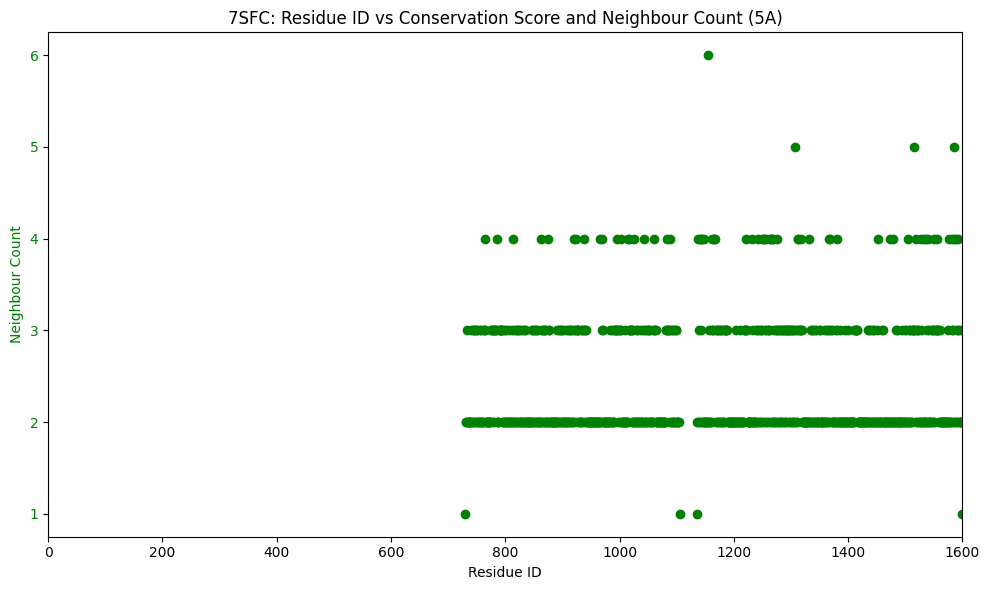

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14796.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14832.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14862.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15085.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15086.
  warni

Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.820   6.650  10.228  12.186  15.371  17.584  19.074  21.891   
731    3.820   0.000   3.796   7.237   9.786  13.017  14.979  16.002  18.574   
732    6.650   3.796   0.000   3.788   6.781   9.541  11.255  12.447  15.269   
733   10.228   7.237   3.788   0.000   3.803   6.154   7.866   9.120  11.760   
734   12.186   9.786   6.781   3.803   0.000   3.797   7.067   9.400  11.616   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  54.820  51.613  51.288  49.201  48.784  49.389  49.624  47.661  44.516   
1597  55.525  52.187  51.609  49.336  48.915  49.242  49.211  47.096  43.796   
1598  51.888  48.511  47.889  45.610  45.253  45.575  45.502  43.347  40.070   
1599  50.539  47.274  46.709  44.423  43.828  44.257  44.462  42.576  39.365   
1600  48.370  45.078  44.303  41.837  41.048  41.300  

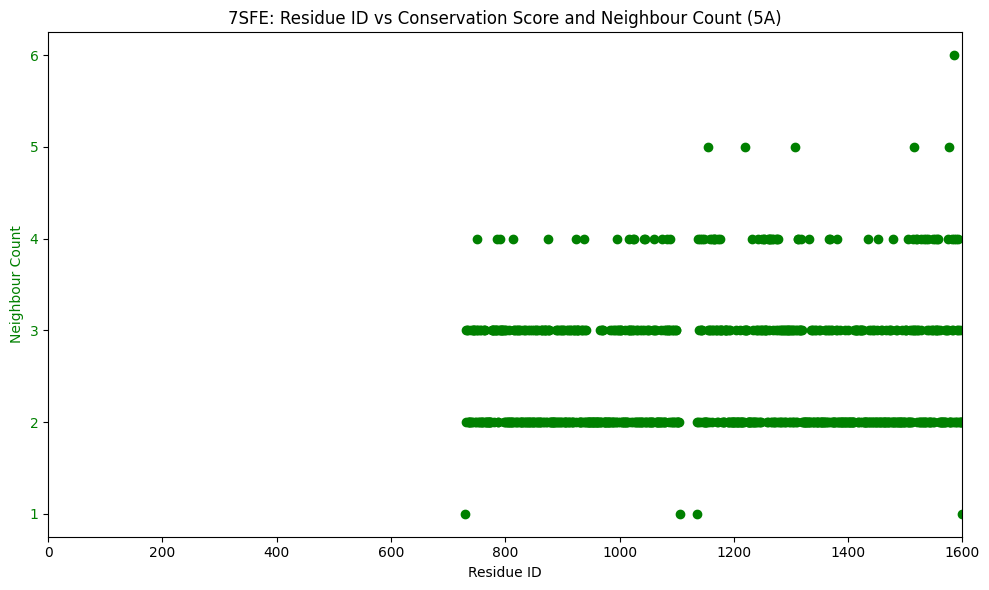

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14730.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14766.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14800.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15144.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15147.
  warni

Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.814   6.309  10.000  12.006  14.982  16.992  18.382  21.316   
731    3.814   0.000   3.797   7.051   9.687  12.705  14.381  15.255  17.989   
732    6.309   3.797   0.000   3.796   6.529   9.112  10.780  12.103  15.084   
733   10.000   7.051   3.796   0.000   3.807   5.993   7.497   8.672  11.426   
734   12.006   9.687   6.529   3.807   0.000   3.790   6.952   9.129  11.290   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1596  54.835  51.718  51.826  49.501  49.080  50.034  50.113  47.824  44.806   
1597  55.477  52.218  52.101  49.587  49.168  49.848  49.672  47.249  44.073   
1598  51.826  48.527  48.372  45.840  45.478  46.144  45.926  43.469  40.318   
1599  50.561  47.385  47.241  44.744  44.146  44.939  45.009  42.801  39.698   
1600  48.581  45.377  44.990  42.331  41.529  42.146  

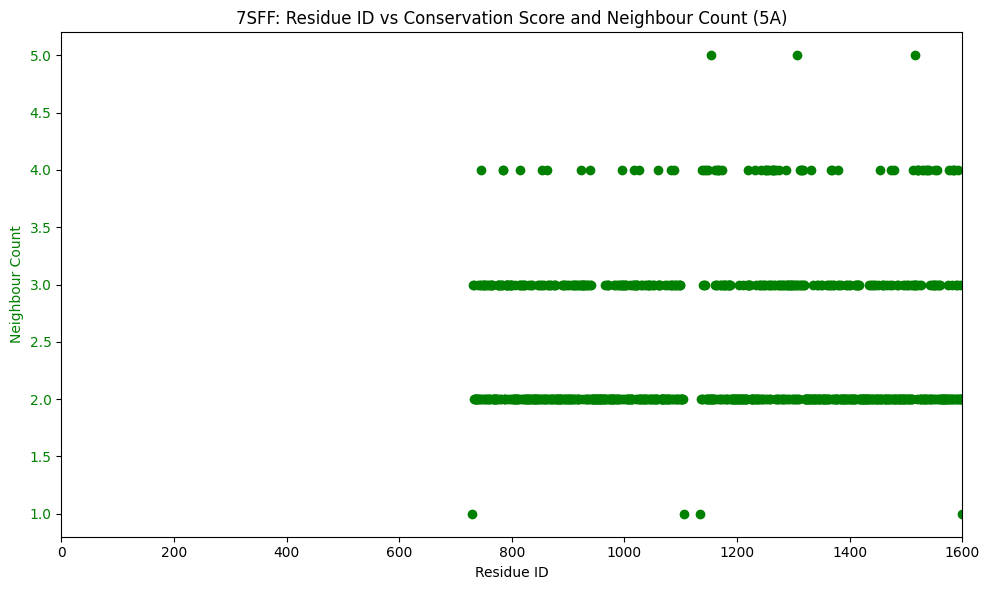

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14291.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14625.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14631.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        730     731     732     733     734     735     736     737     738   \
730    0.000   3.832   6.371  10.042  12.366  15.522  17.125  18.631  21.270   
731    3.832   0.000   3.812   6.953   9.783  12.938  14.253  15.313  17.791   
732    6.371   3.812   0.000   3.791   6.644   9.418  10.775  12.368  15.068   
733   10.042   6.953   3.791   0.000   3.804   6.197   7.455   8.931  11.372   
734   12.366   9.783   6.644   3.804   0.000   3.805   6.823   9.177  10.814   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1597  54.956  51.652  51.475  48.745  47.889  48.058  48.028  45.646  42.284   
1598  51.240  47.906  47.717  44.986  44.192  44.377  44.316  41.907  38.583   
1599  50.237  47.016  46.801  44.097  43.056  43.343  43.588  41.449  38.098   
1600  52.620  49.375  48.928  46.072  44.800  44.852  45.092  43.041  39.549   
1703  66.620  64.174  65.440  63.908  63.696  65.234  

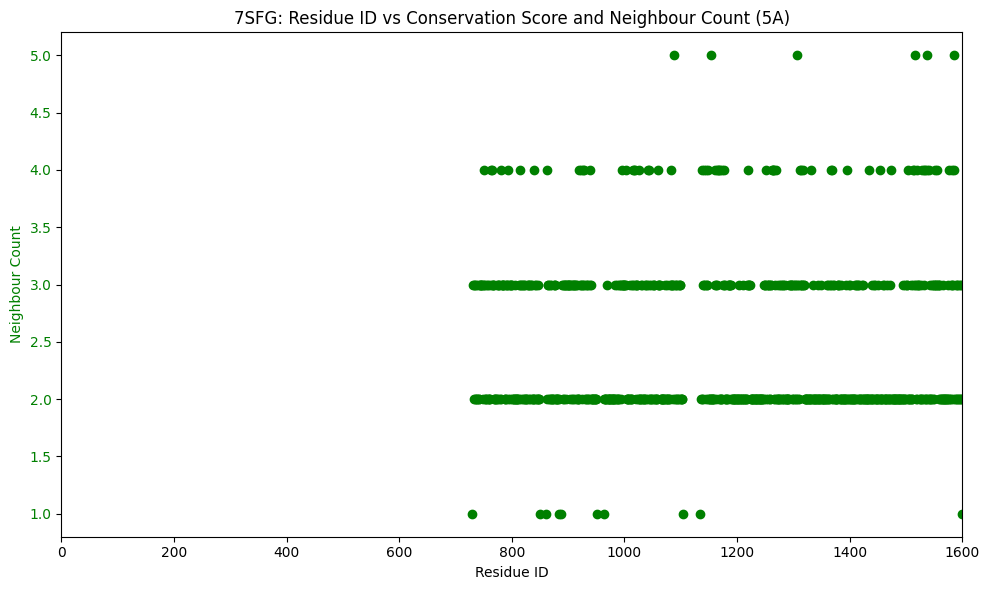

In [38]:
pdb_file_path = ['./pdb/pdb3epz.pdb', './pdb/pdb3pta.pdb', './pdb/pdb3swr.pdb', './pdb/pdb4wxx.pdb',
                 './pdb/pdb4yoc.pdb', './pdb/pdb4z96.pdb', './pdb/pdb4z97.pdb', './pdb/pdb5wvo.pdb',
                 './pdb/pdb5ydr.pdb', './pdb/pdb6k3a.pdb', './pdb/pdb6l1f.pdb', './pdb/pdb6x9i.pdb',
                 './pdb/pdb6x9j.pdb', './pdb/pdb6x9k.pdb', './pdb/pdb7sfc.pdb', './pdb/pdb7sfe.pdb',
                 './pdb/pdb7sff.pdb', './pdb/pdb7sfg.pdb']

# './pdb/pdb8v9u.pdb' excluded

ref_seq = './pdb/AF-P26358-F1-model_v4.pdb'
ref_seq = pdb_to_n_neighbour_vector(ref_seq, angstrom = 5)

for pdb_file in pdb_file_path:
        completed = pdb_to_n_neighbour_vector(pdb_file, angstrom = 5)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 2, 'conservation_score': -0.816}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 2, 'neighbour_count': 3, 'conservation_score': -0.184}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 3, 'neighbour_count': 3, 'conservation_score': -0.879}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 4, 'neighbour_count': 4, 'conservation_score': 0.583}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 5, 'neighbour_count': 4, 'conservation_score': -1.033}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 6, 'neighbour_count': 4, 'conservation_score': -0.642}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 7, 'neighbour_count': 3, 'conservation_score': -0.406}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 8, 'neighbour_count': 2, 'conservation_score': 1.429}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 9, 'neighbour_count': 2, 'conservation_score': 0.265}, {'c

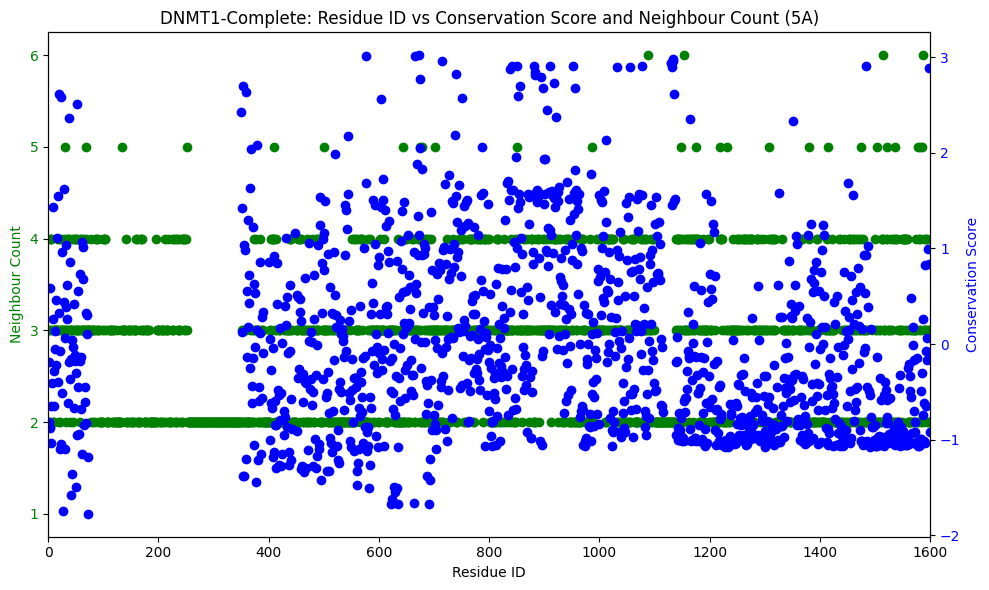

In [39]:
print(updated_ref_seq)
plot_and_calculate_correlation(updated_ref_seq, title='DNMT1-Complete', angstrom = 5)

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_conservation_vs_neighbours(data):
    # Extract data for plotting
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    neighbour_counts = [entry['neighbour_count'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]

    # Check if data is available for plotting
    if not conservation_scores or not neighbour_counts:
        print("Insufficient data to plot.")
        return

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(conservation_scores, neighbour_counts, color='blue', alpha=0.5)
    
    plt.xlabel('Conservation Score')
    plt.ylabel('Neighbour Count')
    plt.title('Conservation Score vs Neighbour Count')
    
    # Calculate and print the correlation
    correlation = np.corrcoef(conservation_scores, neighbour_counts)[0, 1]
    print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
    
    # Display the plot
    plt.show()


Correlation between Conservation Score and Neighbour Count: -0.1296801732323886


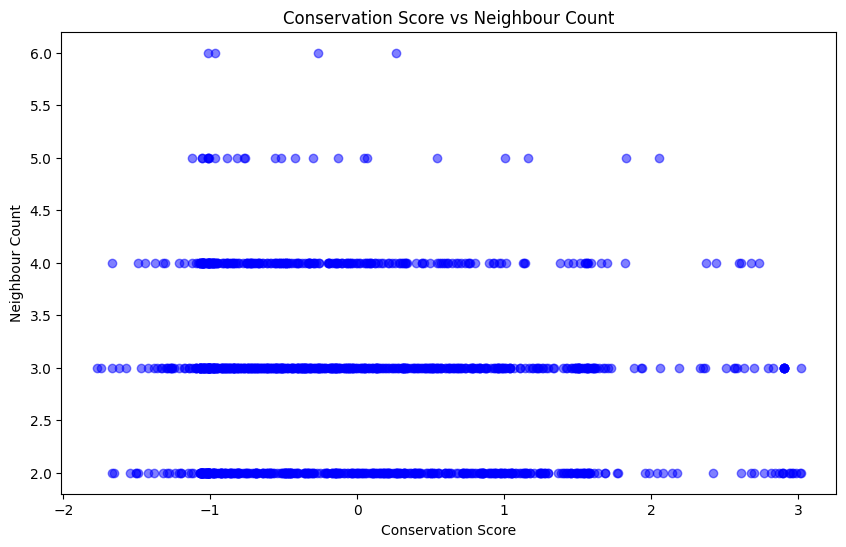

In [41]:
plot_conservation_vs_neighbours(updated_ref_seq)

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_conservation_vs_neighbours(data):
    # Filter data based on conditions
    filtered_data = [entry for entry in data if 'conservation_score' in entry and 'neighbour_count' in entry
                     and ((entry['conservation_score'] is not None and entry['conservation_score'] > 2) or 
                          (entry['neighbour_count'] is not None and entry['neighbour_count'] > 2))]

    # Extract filtered data for plotting
    conservation_scores = [entry['conservation_score'] for entry in filtered_data if entry['conservation_score'] is not None]
    neighbour_counts = [entry['neighbour_count'] for entry in filtered_data if entry['neighbour_count'] is not None]

    # Check if filtered data is available for plotting
    if not conservation_scores or not neighbour_counts:
        print("Insufficient data to plot.")
        return

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(conservation_scores, neighbour_counts, color='blue', alpha=0.5)
    
    # Calculate linear regression parameters
    slope, intercept = np.polyfit(conservation_scores, neighbour_counts, 1)
    plt.plot(conservation_scores, slope * np.array(conservation_scores) + intercept, color='red', label='Regression line')
    
    # Annotate y = mx + c and R^2
    equation_text = f'y = {slope:.2f}x + {intercept:.2f}'
    plt.annotate(equation_text, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
    
    correlation = np.corrcoef(conservation_scores, neighbour_counts)[0, 1]
    r_squared = correlation ** 2
    r_squared_text = f'R² = {r_squared:.2f}'
    plt.annotate(r_squared_text, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)
    
    plt.xlabel('Conservation Score')
    plt.ylabel('Neighbour Count')
    plt.title('Conservation Score vs Neighbour Count')
    plt.legend()
    
    # Display the plot
    plt.show()


ValueError: x and y must be the same size

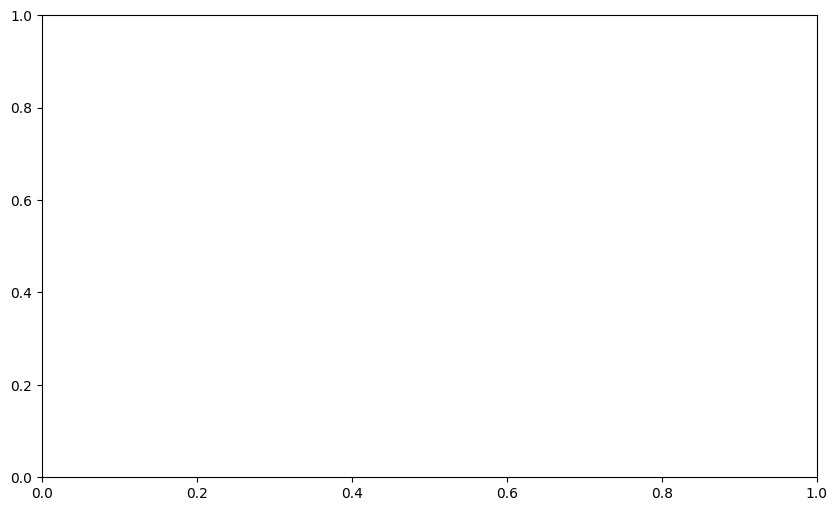

In [43]:
plot_conservation_vs_neighbours(updated_ref_seq)